In [1]:
import pandas as pd #modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os
import pathlib
from pathlib import Path
from datetime import datetime
import time

In [2]:
import os

def find_reports_in_onedrive():
    """
    Scans the subfolders under the current user's OneDrive folder (including variations like 'OneDrive - Company Name')
    and returns the paths of all folders with the prefix 'reports'.

    Returns:
        list: A list of full paths to folders starting with 'reports', or an empty list if none are found.
    """
    # Get the base path to the user's home directory
    user_home = os.path.expanduser("~")

    # Find the OneDrive folder (handles variations like "OneDrive - Company Name")
    onedrive_folder = None
    for folder in os.listdir(user_home):
        if folder.startswith("OneDrive -"):
            onedrive_folder = os.path.join(user_home, folder)
            break

    if not onedrive_folder:
        raise FileNotFoundError("OneDrive folder not found for the current user.")

    # Search for folders with the prefix 'reports' in the OneDrive directory
    report_folders = []
    for root, dirs, files in os.walk(onedrive_folder):
        for dir_name in dirs:
            if dir_name.lower().startswith("reports"):
                report_folders.append(os.path.join(root, dir_name))

    return report_folders

In [3]:
reports_paths=find_reports_in_onedrive()
reports_paths

['C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_control_variables_refinacion',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_cuchillas',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_eventos',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_humidity_measures',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_ops_pendings',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_pre-usos_diligenciamiento_no_cumple',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_quality_deviations',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_refination_deviations',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\reports_visualizacion_data_produccion',
 'C:\\Users\\jdbustamante\\OneDrive - Duratex SA\\control_room\\reports_causa_rechazos']

In [4]:
str_folder_searcher="reports_visualizacion_data_produccion"
for report_path in reports_paths:
    if str_folder_searcher in report_path:
        path=Path(reports_paths[reports_paths.index(report_path)])
path=Path.joinpath(path,"source_and_return_data")
path

WindowsPath('C:/Users/jdbustamante/OneDrive - Duratex SA/reports_visualizacion_data_produccion/source_and_return_data')

# parquet_conversor_excel_file_cleaner

In [5]:
import os
import pandas as pd

def convert_excels_to_parquet(folder_path):
    """
    Converts all Excel files in a folder to Parquet format, removes the original Excel files,
    and skips the most recent Excel file.

    Args:
        folder_path (str): Path to the folder containing Excel files.
    """
    # Ensure the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder {folder_path} does not exist.")

    # List all Excel files in the folder
    excel_files = [f for f in os.listdir(folder_path) if f.endswith(('.xlsx', '.xls'))]

    if not excel_files:
        print("No Excel files found in the folder.")
        return

    # Find the most recent Excel file
    full_paths = [os.path.join(folder_path, f) for f in excel_files]
    most_recent_file = max(full_paths, key=os.path.getmtime)
    most_recent_file_name = os.path.basename(most_recent_file)
    print(f"Skipping the most recent file: {most_recent_file_name}")

    for excel_file in excel_files:
        if excel_file == most_recent_file_name:
            continue  # Skip the most recent file

        try:
            # Full path to the Excel file
            excel_path = os.path.join(folder_path, excel_file)

            # Read the Excel file into a DataFrame
            df = pd.read_excel(excel_path)
            # Convert all data to strings
            df = df.astype(str)

            # Generate the Parquet file path
            parquet_file = os.path.splitext(excel_file)[0] + ".parquet"
            parquet_path = os.path.join(folder_path, parquet_file)

            # Write the DataFrame to a Parquet file
            df.to_parquet(parquet_path, index=False)
            print(f"Converted: {excel_file} -> {parquet_file}")

            # Remove the original Excel file
            os.remove(excel_path)
            print(f"Removed: {excel_file}")

        except Exception as e:
            print(f"Error processing {excel_file}: {e}")

In [6]:
# Example usage
parquet_convertion_folder = Path.joinpath(path,r"data_plots\old_queries")  # Replace with your folder path
convert_excels_to_parquet(parquet_convertion_folder)

Skipping the most recent file: causa_rechazos_aperturas_nariz_2025-02-01_2025-02-03.xlsx
Error processing causa_rechazos_aperturas_nariz_2025-01-01_2025-01-16.xlsx: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
Error processing causa_rechazos_aperturas_nariz_2025-01-01_2025-01-19.xlsx: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to 

# Work as usual

In [7]:
directory = Path.joinpath(path,"data_plots") #get current work directory
directory.mkdir(exist_ok=True)
matching_files = list(directory.glob("*obj*.xlsx"))  # Busca archivos que contengan 'obj' y tengan extensión .xlsx
print("Archivos encontrados:", matching_files)

Archivos encontrados: [WindowsPath('C:/Users/jdbustamante/OneDrive - Duratex SA/reports_visualizacion_data_produccion/source_and_return_data/data_plots/test_obj_aperturas_nariz.xlsx'), WindowsPath('C:/Users/jdbustamante/OneDrive - Duratex SA/reports_visualizacion_data_produccion/source_and_return_data/data_plots/test_obj_causa_rechazos.xlsx')]


In [8]:
dict_data_pointer={} #dict to store files as dfs
for i in matching_files: # Read the Excel file 
    file_path = str(i)  # Update this with the path
    df = pd.read_excel(file_path)
    print(file_path)
    df_name=file_path.split("obj_")[1].split(".")[0] #split str with "obj_" and the  "." char and take the file name
    date_col="Fecha" #default col name with dates
    if "aperturas" in file_path.lower(): #if excel name file contains "aperturas", change col name with dates
        date_col="Fecha Paro"
    row_numbers_nan = df.index[df[date_col].isna()].tolist() # Get the row numbers where 'Fecha' or 'Fecha Paro' is NaN
    row_numbers = list(set(row_numbers_nan)) # lists of row with nan numbers
    filtered_df = df.drop(index=row_numbers) # Filter the DataFrame to keep only the rows that are not in row_numbers
    dict_data_pointer[f"{df_name}"]=filtered_df #store filtered df in dictionary data pointer
print(list(dict_data_pointer.keys())) #see keys on dictionary to check callability

C:\Users\jdbustamante\OneDrive - Duratex SA\reports_visualizacion_data_produccion\source_and_return_data\data_plots\test_obj_aperturas_nariz.xlsx
C:\Users\jdbustamante\OneDrive - Duratex SA\reports_visualizacion_data_produccion\source_and_return_data\data_plots\test_obj_causa_rechazos.xlsx
['aperturas_nariz', 'causa_rechazos']


In [9]:
data_pointer_ar="aperturas_nariz" #select df of aperturas de nariz
df_ar=dict_data_pointer[data_pointer_ar] #mask df of aperturas de nariz with alias df_ar
dates_col_name_ar="Fecha Paro" #name of col with dates in df
df_ar[dates_col_name_ar] =df_ar.loc[:,dates_col_name_ar].apply(lambda x:x.strftime("%Y-%m-%d")) #convert dates to desired format
df_ar.loc[:,dates_col_name_ar]

0     2025-02-01
1     2025-02-01
2     2025-02-01
3     2025-02-01
4     2025-02-01
5     2025-02-01
6     2025-02-02
7     2025-02-03
8     2025-02-03
9     2025-02-03
10    2025-02-03
11    2025-02-03
12    2025-02-04
13    2025-02-04
14    2025-02-04
15    2025-02-04
16    2025-02-04
17    2025-02-04
18    2025-02-04
Name: Fecha Paro, dtype: object

In [10]:
dates_ar=sorted(list(set([ date_str for date_str in df_ar.loc[ :, dates_col_name_ar] ]))) #get dates as str unique of current df
dates_ar

['2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04']

# Check matches on initial hour & final hour
* remove apertures that are duplicate for changes on dat shift

In [11]:
list_dropped_idx_rows=[]
for date_ar in dates_ar:
    print(date_ar)
    df_seeker=df_ar.loc[df_ar["Fecha Paro"]==date_ar] #filter by date
    rows_df_seeker=df_seeker.index #get idx of df for current date
    last_row=rows_df_seeker[-1] #to avoid out of range
    print(last_row)
    for row in rows_df_seeker:
        print(row)
        if row==last_row:
            continue #jump to next date
        if df_seeker.at[row,"Hora Final"]==df_seeker.at[row+1,"Hora Inicial"]:
            list_dropped_idx_rows.append(row+1) #add idx to be dropped
    print("idxs to drop are {}".format(list_dropped_idx_rows))
df_ar.drop(list_dropped_idx_rows,inplace=True) #drop selected rows for current date
df_ar

2025-02-01
5
0
1
2
3
4
5
idxs to drop are [1]
2025-02-02
6
6
idxs to drop are [1]
2025-02-03
11
7
8
9
10
11
idxs to drop are [1]
2025-02-04
18
12
13
14
15
16
17
18
idxs to drop are [1, 17, 18]


,Linea,Proceso,Tipo Paro,Fecha Paro,Hora Inicial,Hora Final,Descripción Equipo,Modo de Fallo,Obversación,Tiempo Parada,Turno,Calibre,Columna1
0,CRUDO,300 - SECADO PRIMERA Y SEGUNDA ETAPA,PARO PROGRAMADO,2025-02-01,09:00:00,13:00:00,300 SECADO PRIMERA Y SEGUNDA ETAPA,LIMPIEZA DE EQUIPOS - PRO,se para linea para realizar limpiesa a secader...,240.01,2,9,153659
2,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",ELÉCTRICO,2025-02-01,13:10:00,13:18:00,400.402.00 BUNKER DE FORMACION,FALLA DE MOTOR - ELC,"se va a fallo en esparcidor #3 , se da reset ,...",8.00,3,9,153659
3,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",ELÉCTRICO,2025-02-01,13:25:00,13:36:00,400.402.00 BUNKER DE FORMACION,FALLA DE MOTOR - ELC,"se va a fallo en esparcidor #3 , se da reset ,...",11.00,3,9,153659
4,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",ELÉCTRICO,2025-02-01,13:48:00,14:07:00,400.402.00 BUNKER DE FORMACION,FALLA DE MOTOR - ELC,"se va a fallo en esparcidor #3 , se da reset ,...",19.00,3,9,153659
5,CRUDO,300 - SECADO PRIMERA Y SEGUNDA ETAPA,PRODUCCIÓN,2025-02-01,20:20:00,20:35:00,300 SECADO PRIMERA Y SEGUNDA ETAPA,VARIACION TEMPERATURA - PRO,se presento un variacion de alta temperatura e...,15.00,3,9,153659
6,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",PRODUCCIÓN,2025-02-02,09:51:00,09:53:00,400 FORMACION Y PREPRENSA,DETECCIÓN DE METAL - MEC,Metal banda 415,2.00,2,9,153660
7,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",PCP,2025-02-03,23:24:00,23:29:00,400 FORMACION Y PREPRENSA,CAMBIO DE CALIBRE - PCP,Cambio de 9 mm a 5.5 mm,5.00,1,5.5,153661
8,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",PRODUCCIÓN,2025-02-03,01:38:00,01:41:00,400 FORMACION Y PREPRENSA,DETECCIÓN DE METAL - MEC,Metal banda 415,3.00,1,5.5,153661
9,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",PCP,2025-02-03,13:41:00,14:00:00,400 FORMACION Y PREPRENSA,CAMBIO DE CALIBRE - PCP,Se cambia a 9mm / 18 ft,19.00,3,9,153663
10,CRUDO,"400 - FORMACION, PRE-PRENSADO & CORTE",PRODUCCIÓN,2025-02-03,14:15:00,14:18:00,400 FORMACION Y PREPRENSA,VARIACION PESO - PRO,Al arrancar se presenta alto valor en la densi...,3.00,3,9,153663


In [12]:
amt_apertura_nariz=df_ar.groupby(dates_col_name_ar).count().T.iloc[0] #for each production stop there is an apertura de nariz and take those values
amt_apertura_nariz=np.array(amt_apertura_nariz) #agsin amt of aperturas per day on array of numpy
amt_apertura_nariz

array([5, 1, 5, 5])

In [13]:
data_pointer="causa_rechazos" #start with df with rejected panels number per day and cause
df=dict_data_pointer[data_pointer] #mask causa_rechazos with df alias
dates_col_name="Fecha" #date col on causa_rechazos
cause_col_name="Notas movimiento" #rejected causes col name
nan_causes="causa no especifica" #str to replace nans on rejected causes col name
df.loc[:,[cause_col_name]]=df.loc[:,[cause_col_name]].fillna(value=nan_causes) #particular cleasing for causa_rechazos df; fill not specified rejected causes
df.loc[:,[cause_col_name]]

,Notas movimiento
0,causa no especifica
1,AMPOLLADAS
2,ALTO CALIBRE
3,BAJO CALIBRE
4,ALTO CALIBRE
5,AMPOLLADA
6,BAJO CALIBRE


### New approach:
* Drop date col on causa rechazos and replace w/ str date col
* Convert str to datetime to make call correctly

In [14]:
try: #attemp to drop cummulative total row
    df=df.loc[1:,:] #drop first row cause is a total row
except:
    pass
df.reindex(range(len(df)))
df[dates_col_name]=df.loc[:,dates_col_name].apply(lambda x:x.strftime("%Y-%m-%d")) #convert dates to desired format
df.loc[:,dates_col_name]

C:\Users\jdbustamante\AppData\Local\Temp\ipykernel_26228\1804187861.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[dates_col_name]=df.loc[:,dates_col_name].apply(lambda x:x.strftime("%Y-%m-%d")) #convert dates to desired format


1    2025-02-01
2    2025-02-01
3    2025-02-01
4    2025-02-01
5    2025-02-02
6    2025-02-03
Name: Fecha, dtype: object

In [15]:
ignored_articles=["de","s","-"] #+#articles to remove for cause name-->make basic cause labelling

In [16]:
def remove_specific_chars(string=None):
    new_cause_basic_name=string
    nan_causes="causa no especifica" #str to replace nans on rejected causes col name
    ignored_articles=["de","s","-"] #+#articles to remove for cause name-->make basic cause labelling
    ignored_digits=[str(number) for number in range(9+1)] #list to remove numbers from string
    for ignored_article in ignored_articles:
        if string==nan_causes: #do not remove chars on nan_causes
            continue
        new_cause_basic_name=new_cause_basic_name.replace(ignored_article,"") #remove articles from cause name
        new_cause_basic_name=" ".join(new_cause_basic_name.split()) #remove spaces
        new_cause_basic_name="".join([i for i in new_cause_basic_name if not i.isdigit()])
        print(new_cause_basic_name)
    return new_cause_basic_name

In [17]:
causes=[str(i).lower() for i in df[cause_col_name].unique()] #day causes on lower case
for idx_cause,cause in enumerate(causes): #run through causes and idx from 0-len(causes)
    causes[idx_cause]=remove_specific_chars(string=cause) #" ".join(new_cause_basic_name.split()) #clean str for extra spaces
causes=list(set(causes)) #get unique instances of causes (not duplicates on causes), sorted alpha descending
time_stamp_dates=list([ i for i in [ df.loc[ :, dates_col_name].unique() ][::-1] ][0]) #get dates as time_stamps
#dates = [str(j).split(" ")[0] for j in time_stamp_dates]  # dates to convert each time stamp to str and remove hh:mm:ss info
dates=sorted(time_stamp_dates) #sorted dates aperturas ascending
causes=sorted(causes)
dates,causes

ampolladas
ampollada
ampollada
alto calibre
alto calibre
alto calibre
bajo calibre
bajo calibre
bajo calibre
ampollada
ampollada
ampollada


(['2025-02-01', '2025-02-02', '2025-02-03'],
 ['alto calibre', 'ampollada', 'bajo calibre'])

### Unique ID color for every cause

In [18]:
colors_id_path=Path.joinpath(directory,"valid_causes_rejected_panels.txt")
causes_colors_df = pd.read_csv(colors_id_path, sep=",",index_col=0,header=0,on_bad_lines='skip')
causes_colors_df["variations"]=causes_colors_df["variations"].apply(lambda x:x.replace(";",","))
causes_colors_df

,variations,acronyms,color
idx,,,
0,"[""explotado"",""explotada""]",[],'1'
1,"[""alto calibre""]","[""a.c""]",'2'
2,"[""bajo calibre""]","[""b.c""]",'3'
3,"[""retencion""]",[],'4'
4,"[""maltratado"",""maltratada"",""maltrato""]",[],'4'
5,"[""mancha"",""manchada"",""manchado""]",[],'5'
6,"[""falta de curado""]","[""f.c"";""f.curado""]",'6'
7,"[""ampollado"",""ampollada""]",[],'7'
8,"[""master panel corto""]","[""m.p corto"";""m.p.c""]",'8'


# In case rejected causes is empty:
* generate dummy causes, all current valid causes from df of valid causes

In [19]:
if len(causes)<1: #causes list is empty
    causes=[eval(element)[0] for element in list(causes_colors_df.loc[:,list(causes_colors_df.columns)[0]].values)]
causes

['alto calibre', 'ampollada', 'bajo calibre']

## Dates check
* for now, aperturas de nariz file contains dates that are missing on causa rechazos file

In [20]:
# Set the maximum time limit (in seconds)
time_limit = 30  # Break the loop after 10 seconds

# Record the start time
start_time = time.time()
while dates_ar!=dates: # [:len(dates)]
    for date_ar_idx,date_ar in enumerate( dates_ar ): #run through dates of aperturas
        print(date_ar_idx)
        print("current date of apertures ",date_ar)
        print("current dates of causas rechazos ",dates)
        if date_ar not in dates: #replace current dates with dates of aperturas de nariz: non missing dates current file
            print("{} of apertures not in {}".format(date_ar,dates))
            dates.insert(date_ar_idx,date_ar)
            print("nueva lista de fechas para causa rechazos ",dates)
    # Check if the time limit has been exceeded
    if time.time() - start_time > time_limit:
        print("Time limit reached. Exiting loop.")
        break
    else:
        print("Time limit not reached")

0
current date of apertures  2025-02-01
current dates of causas rechazos  ['2025-02-01', '2025-02-02', '2025-02-03']
1
current date of apertures  2025-02-02
current dates of causas rechazos  ['2025-02-01', '2025-02-02', '2025-02-03']
2
current date of apertures  2025-02-03
current dates of causas rechazos  ['2025-02-01', '2025-02-02', '2025-02-03']
3
current date of apertures  2025-02-04
current dates of causas rechazos  ['2025-02-01', '2025-02-02', '2025-02-03']
2025-02-04 of apertures not in ['2025-02-01', '2025-02-02', '2025-02-03']
nueva lista de fechas para causa rechazos  ['2025-02-01', '2025-02-02', '2025-02-03', '2025-02-04']
Time limit not reached


# Generate data to plotting

In [21]:
weight_counts={i:[0]*len(causes) for i in dates} #make dict to store panel per cause per day
weight_counts

{'2025-02-01': [0, 0, 0],
 '2025-02-02': [0, 0, 0],
 '2025-02-03': [0, 0, 0],
 '2025-02-04': [0, 0, 0]}

# TODO
* apply directive to clean classifications and search correctly on causa rechazos

In [22]:
name_of_rejected_panels_col="Salidas (inv.)" #actual name of rejected panels col-->start completion of panel per cause per day
for date in dates: #run through dates
    try: #------->try to search by respective date. except: date not in cause rechazos, generate a date entry on weight counts with all causes on 0<-----------
        print(date, type(date))
        print(date_col,cause_col_name)
        df_cols_date_search=df.loc[:,:"Notas movimiento"].groupby([date_col,cause_col_name]).sum().T.loc[:,date] #total amt of panels per cause, per date
    except: #ValueError:
        #print(ValueError)
        continue #next iteration, current date with all 0s on causes
    cols_date_search_causes=df_cols_date_search.columns #causes col names for current date filter
    for cause,z in zip(causes,range(len(causes))): # run through causes and idx from 0-len(causes)
        for current_date_cause in cols_date_search_causes: # # run through causes per day
            current_cause=current_date_cause.lower() #apply lower case convertion
            current_cause=remove_specific_chars(string=current_cause) #cause on current df, remove articles to basic cause name
            if cause in current_cause: #cause match case: if cause in current cause per day, 
                panels_per_cause=df_cols_date_search[current_date_cause].T[name_of_rejected_panels_col] #get panels rejected by current cause
                print(f"{cause}:"+str(panels_per_cause)) #print cause and panels
                weight_counts[date][z]=panels_per_cause #store on dict date:
    #print(date)
weight_counts

2025-02-01 <class 'str'>
Fecha Notas movimiento
alto calibre
alto calibre
alto calibre
alto calibre:14
ampolladas
ampollada
ampollada
bajo calibre
bajo calibre
bajo calibre
alto calibre
alto calibre
alto calibre
ampolladas
ampollada
ampollada
ampollada:5
bajo calibre
bajo calibre
bajo calibre
alto calibre
alto calibre
alto calibre
ampolladas
ampollada
ampollada
bajo calibre
bajo calibre
bajo calibre
bajo calibre:1
2025-02-02 <class 'str'>
Fecha Notas movimiento
ampollada
ampollada
ampollada
ampollada
ampollada
ampollada
ampollada:1
ampollada
ampollada
ampollada
2025-02-03 <class 'str'>
Fecha Notas movimiento
bajo calibre
bajo calibre
bajo calibre
bajo calibre
bajo calibre
bajo calibre
bajo calibre
bajo calibre
bajo calibre
bajo calibre:2
2025-02-04 <class 'str'>
Fecha Notas movimiento


{'2025-02-01': [14, 5, 1],
 '2025-02-02': [0, 1, 0],
 '2025-02-03': [0, 0, 2],
 '2025-02-04': [0, 0, 0]}

In [23]:
construc_data_to_stacked=list(weight_counts.items()) #get keys and values of weight_counts
array_rejected_panels_per_cause_per_day=np.zeros((len(causes),len(dates))) #make array of zeros to replace data from rows as cols
for i in range(len(construc_data_to_stacked)): # run through idx from 0-len(amt of dates)
    array_rejected_panels_per_cause_per_day[:,i]=np.array(construc_data_to_stacked[i][-1]).T #take panels values, transpose and store on array of rejected panels
weight_count_causes={i:array_rejected_panels_per_cause_per_day[j,:] for i,j in zip(causes, range(len(causes)))} #reconstruct weight counts: keys as causes, rows rejected panels per specific cause per day
weight_count_causes

{'alto calibre': array([14.,  0.,  0.,  0.]),
 'ampollada': array([5., 1., 0., 0.]),
 'bajo calibre': array([1., 0., 2., 0.])}

In [24]:
bar_cause_labels=[[]]*len(causes) #make labels to display on rectangle bar data: inside rectangle to do not display 0 values
for bar_values,bar_idx,cause in zip(bar_cause_labels,range(len(causes)),causes): #run through bbar_cause_labels and idx from 0-len(causes) and causes
    bar_values=[str(int(weight_count_causes[cause][i])).replace("0"," ") if len( str(int(weight_count_causes[cause][i])) )<2 else str(int(weight_count_causes[cause][i])) for i in range(len(dates)) ] #replace 0 only values with " " #
    bar_cause_labels[bar_idx]=bar_values #agsin rectangle value
bar_cause_labels

[['14', ' ', ' ', ' '], ['5', '1', ' ', ' '], ['1', ' ', '2', ' ']]

# TODO
* organizar orden de stacked bar para mostrar primero las causas con más paneles rechazados

In [25]:
colors_available=mcolors.TABLEAU_COLORS
colors_available

{'tab:blue': '#1f77b4',
 'tab:orange': '#ff7f0e',
 'tab:green': '#2ca02c',
 'tab:red': '#d62728',
 'tab:purple': '#9467bd',
 'tab:brown': '#8c564b',
 'tab:pink': '#e377c2',
 'tab:gray': '#7f7f7f',
 'tab:olive': '#bcbd22',
 'tab:cyan': '#17becf'}

In [26]:
colors_available_keys=list(colors_available)
#colors_available_keys.remove('tab:olive')
colors_available_keys

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [27]:
causes_color_idxs=[]
for j in range(len(causes)):
    for i in range(len(causes_colors_df)):
        if causes[j] in causes_colors_df["variations"][i]:
            causes_color_idxs.append(int(eval(causes_colors_df.at[i,"color"])))
causes_color_idxs

[2, 7, 3]

In [28]:
colors_choosen={cause:colors_available_keys[idx_color] for cause,idx_color in zip(causes,causes_color_idxs)}
colors_choosen

{'alto calibre': 'tab:green',
 'ampollada': 'tab:gray',
 'bajo calibre': 'tab:red'}

In [29]:
fontsz=11 #define font size of plot components
matplotlib.rcParams.update({'font.size': fontsz}) #update font size for plot components of matplotlib

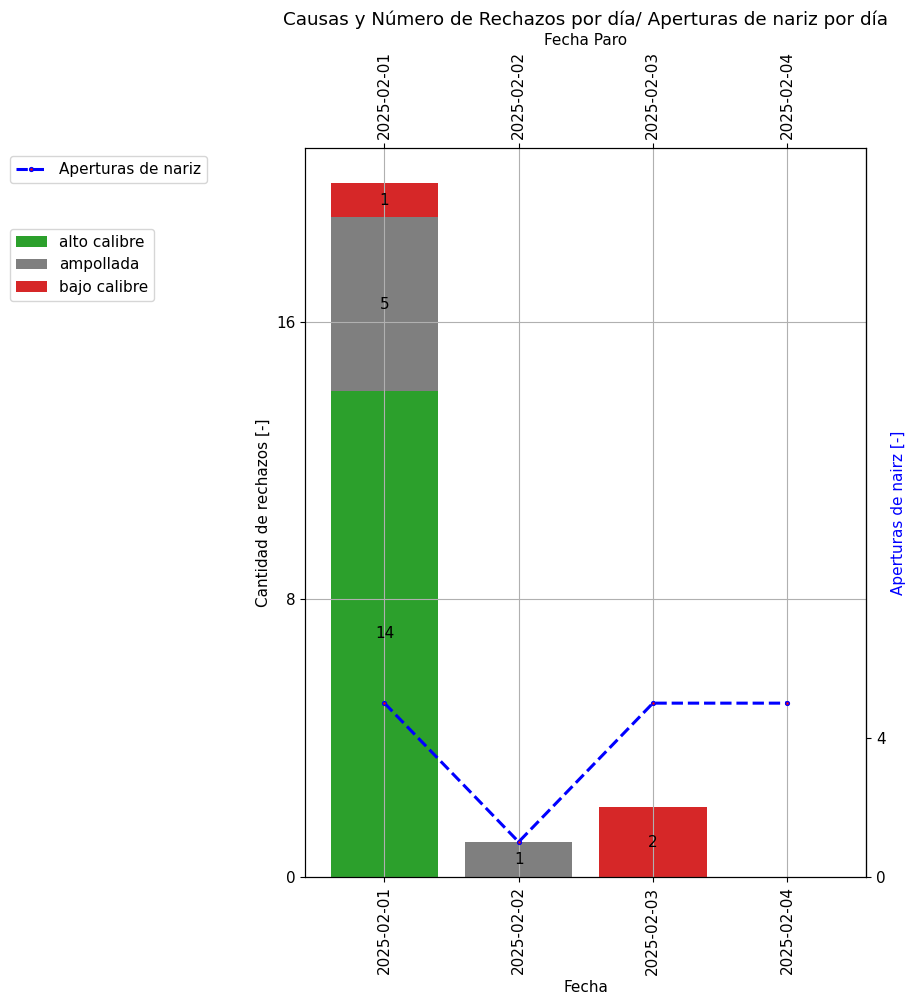

In [30]:
fig, ax = plt.subplots()
fig.tight_layout()  # Adjust layout to prevent clipping of labels
fig.set_figheight(8.4)
#fig.set_size_inches(50, 40) #set plot size
#plot aperturas
amt_dates=len(dates)
bottom = np.zeros(amt_dates) #initial axis for stacked bars plotting
plt.grid() #make grid mesh
max_bottom=0 #to store max of bottoms in construction of bar
for (data_label,weight_count),bar_value_stick,color_cause in zip(weight_count_causes.items(),bar_cause_labels,colors_choosen.values()): #run through dates, rejected per cause per dates, labels of values of rejected per cause per day 
    p = ax.bar(dates, weight_count, label=data_label, bottom=bottom,color=color_cause) #take bar plot elements: rectangle(attribute 1, attribute 2, ...)
    bottom += weight_count #make new start to plot next top rectangle
    check_bottom=np.max(bottom)
    if check_bottom>max_bottom:
        max_bottom=check_bottom #to generate ylim of causas rechazos
    ax.bar_label(p, labels=bar_value_stick, label_type='center',color="black",padding=0) #add bar height str value on bar center
leq=ax.legend(bbox_to_anchor=(-0.54,0.9),loc="upper left") #generate legend box for bar plot and set its ubication
amt_xticks=range(len(dates))
ax.set_xticks(amt_xticks)
ax.set_xticklabels(dates,rotation=90) #rotate x axis labels 90º to be displayed vertically
ax.set_xlabel(dates_col_name) #name of bar plot x axis
rejected_panels_values=np.array(list(weight_counts.values()))
max_rejected_axis=np.max(rejected_panels_values) #get max of all data
max_rejected_axis_step=8
ax.set_yticks(np.arange(0, max_rejected_axis+max_bottom, max_rejected_axis_step)) #set y axis label values: axis pitch=10 unds
ax.set_ylabel("Cantidad de rechazos [-]") #y axis name for bar plot
ax.set_aspect('auto')
#plot aperturas
ax_ar = ax.twiny() #copy bar plot element to plot easily amt of aperturas de nariz
ax_ar.sharex(ax)
amt_xticks_ar=range(len(dates))
ax_ar.set_xticks(amt_xticks_ar)
ax_ar.set_xticklabels(dates_ar,rotation=90) #rotate x axis labels 90º to be displayed vertically
ax_ar.set_xlabel(dates_col_name_ar) #name of bar plot x axis
ax_ar.plot(amt_apertura_nariz,label="Aperturas de nariz",linewidth=fontsz/5,linestyle='dashed',color="b",marker=".",
        markersize=fontsz/2,markerfacecolor='red') #plot aperturas de nariz by day
ax_ar.set_xticklabels(dates_ar,rotation=90)
leq_ar=ax_ar.legend(bbox_to_anchor=(-0.54,1),loc="upper left") #generate legend box for line plot and set its ubications sligthy over cause legend
secax_y2 = ax_ar.secondary_yaxis("right", functions=(lambda x: x, lambda x: x)) #make new y axis for aperturas, same lambda to avoid complexity in instrucctions
secax_y2.set_ylabel("Aperturas de nairz [-]",color='b') #change color of y axis to blue
max_apertures_axis=np.max(amt_apertura_nariz) #to set max lim of aperturas y axis
max_apertures_axis_step=4
secax_y2.set_yticks(np.arange(0, max_apertures_axis*(1.4), max_apertures_axis_step)) #change y axis limits and pitch to 5
ax_ar.set_aspect('auto')
imgs_folder="/imgs_reports_daily" #str with name to save plots
imgs_type_folder="/qty_rejecteds_apertures"
imgs_year_folder=f"/year_{dates[0].split("-")[0]}"
imgs_month_folder=f"/month_{dates[0].split("-")[1]}"
img_name="/fail_modes_Qty_rechazos" #name of img file
str_today=datetime.today().strftime('%Y-%m-%d') #asign date of generation
plt.title("Causas y Número de Rechazos por día/ Aperturas de nariz por día") #make title
directory_to_save = Path(str(directory)+imgs_folder+imgs_type_folder+imgs_year_folder+imgs_month_folder) # get directory to save plot
directory_to_save.mkdir(exist_ok=True)
plt.savefig(str(directory_to_save)+img_name+dates[0]+"_"+dates_ar[-1]+"_"+str_today+".png", bbox_inches='tight') #store img plot
plt.show()

In [31]:
df_to_export=pd.concat([df, df_ar], axis=1) #merge dfs to store data as old queries

In [32]:
df_to_export.to_excel(str(directory)+f"/old_queries/{data_pointer}_{data_pointer_ar}_"+dates[0]+"_"+dates_ar[-1]+".xlsx") #save current query to old_queries

# Plot with sorted stacked bars
* make innner outter index data frame, sort by inner index (causes)

In [33]:
"""times=[]
for i in dates:
    for j in range(len(causes)):
        times.append(i)
times_causes_array=[times,causes*len(dates)]
times_causes_array"""

'times=[]\nfor i in dates:\n    for j in range(len(causes)):\n        times.append(i)\ntimes_causes_array=[times,causes*len(dates)]\ntimes_causes_array'

In [34]:
"""data=np.array(list(weight_count_causes.values())).T.flatten()
data.shape"""

'data=np.array(list(weight_count_causes.values())).T.flatten()\ndata.shape'

In [35]:
"""s=pd.Series(data, index=times_causes_array)"""

's=pd.Series(data, index=times_causes_array)'

In [36]:
"""s1=s.groupby(level=[0]).apply(lambda x:x.groupby(level=[1]).sum().sort_values(ascending=True))
s1"""

's1=s.groupby(level=[0]).apply(lambda x:x.groupby(level=[1]).sum().sort_values(ascending=True))\ns1'

In [37]:
"""s1.unstack().plot.bar(stacked=True)"""

's1.unstack().plot.bar(stacked=True)'

In [38]:
"""data,idxs=weight_count_causes.values(),weight_count_causes.keys()

data=pd.DataFrame(index=idxs,data=data,columns=dates).T
data.plot.bar()"""

'data,idxs=weight_count_causes.values(),weight_count_causes.keys()\n\ndata=pd.DataFrame(index=idxs,data=data,columns=dates).T\ndata.plot.bar()'